# SolarCast — Model Evaluation: Linear Regression vs XGBoost (2023–2025)
This notebook compares the proof-of-concept Linear Regression model (Polynomial version) 
with the current best XGBoost model trained on the capacity-scaled 2023–2025 dataset.

**Goals:**
- Train both models on the same dataset and split for a fair comparison.
- Evaluate using R², RMSE, and MAE.
- Visualise predictions vs actual values.
- Analyse residual patterns to identify model strengths and weaknesses.


### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import joblib
import xgboost as xgb


### Load & Prepare Dataset

In [25]:
# Load Cleaned Data and view head
df = pd.read_csv("../../Cleaned Data/Cleaned_National_Irish_Weather_Solar_2023-2025.csv", parse_dates=['date'])
dates = df['date']
df.head()

,date,rain,maxtp,mintp,glorad,solargen
0,2023-04-01,2.99,11.81,5.82,1088.88,2127.56
1,2023-04-02,0.00,12.19,3.68,1329.00,2666.57
2,2023-04-03,0.54,11.25,5.64,731.12,2370.33
3,2023-04-04,4.15,12.04,7.10,835.75,3397.26
4,2023-04-05,2.44,13.50,7.40,820.00,2005.28


### Parse Dates and Add Seasonal Features

In [10]:
# Convert to datetime and extract useful calendar features
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['month'] = df['date'].dt.month
df['dayofyear'] = df['date'].dt.dayofyear
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

### Scale Solar Generation Data to Adjust for Yearly Capacity Increases 2023-2025

In [11]:
df['year'] = df['date'].dt.year

# Calculate the 95th percentile daily solar generation per year
percentiles_95 = df.groupby('year')['solargen'].quantile(0.95)
print("Original 95th Percentiles:")
print(percentiles_95)

# Use 2024 as the reference capacity level
ref_year = 2024
ref_value = percentiles_95.loc[ref_year]

# Compute scaling factors for each year
scaling_factors = percentiles_95.apply(lambda x: ref_value / x)
print("\nScaling Factors (relative to 2024):")
print(scaling_factors)

# Apply scaling factors to solar generation
df['solargen_scaled'] = df.apply(
    lambda row: row['solargen'] * scaling_factors.loc[row['year']],
    axis=1
)

# Check new percentiles after scaling
new_percentiles_95 = df.groupby('year')['solargen_scaled'].quantile(0.95)
print("\nNew 95th Percentiles After Scaling:")
print(new_percentiles_95)


Original 95th Percentiles:
year
2023     9789.52
2024    17096.33
2025    50659.74
Name: solargen, dtype: float64

Scaling Factors (relative to 2024):
year
2023    1.746391
2024    1.000000
2025    0.337474
Name: solargen, dtype: float64

New 95th Percentiles After Scaling:
year
2023    17096.33
2024    17096.33
2025    17096.33
Name: solargen_scaled, dtype: float64


### Select Features and Target

In [12]:
# Define feature sets
linear_features = ["glorad", "maxtp", "mintp", "rain"]
xgb_features = linear_features + ["month", "dayofyear", "sin_doy", "cos_doy"]
target = "solargen_scaled"

print("Linear Features:", linear_features)
print("XGBoost Features:", xgb_features)


Linear Features: ['glorad', 'maxtp', 'mintp', 'rain']
XGBoost Features: ['glorad', 'maxtp', 'mintp', 'rain', 'month', 'dayofyear', 'sin_doy', 'cos_doy']


### Assign Features and Target

In [13]:
X_linear = df[linear_features]
X_xgb = df[xgb_features]
y = df['solargen_scaled']

In [14]:
### Train-Test Split

from sklearn.model_selection import train_test_split

# 80/20 split (same random_state for reproducibility)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_linear, y, test_size=0.2, random_state=42
)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42
)

print(f"Random split: {X_train_lin.shape[0]} train, {X_test_lin.shape[0]} test")

Random split: 657 train, 165 test


### Build Polynomial Baseline Features (Reduced2 + glorad^2)

In [15]:
# Use glorad, maxtp, rain + glorad^2 (drop mintp to avoid multicollinearity)
X_linear_poly = df[['glorad', 'maxtp', 'rain']].copy()
X_linear_poly['glorad_sq'] = df['glorad'] ** 2

# Align with existing random split indices
X_train_lin_poly = X_linear_poly.loc[X_train_lin.index]
X_test_lin_poly  = X_linear_poly.loc[X_test_lin.index]


### Train Polynomial Linear Regression (OLS)

In [16]:
lin_model = LinearRegression()
lin_model.fit(X_train_lin_poly, y_train_lin)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Evaluate Polynomial Linear Regression

In [17]:
# Predictions
y_pred_train_lin = lin_model.predict(X_train_lin_poly)
y_pred_test_lin  = lin_model.predict(X_test_lin_poly)

# Metrics
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

results_linear = {
    "model": "Polynomial Linear (glorad, maxtp, rain, glorad^2)",
    "r2_train": r2_score(y_train_lin, y_pred_train_lin),
    "r2_test": r2_score(y_test_lin, y_pred_test_lin),
    "rmse_train": rmse(y_train_lin, y_pred_train_lin),
    "rmse_test": rmse(y_test_lin, y_pred_test_lin),
    "mae_train": mean_absolute_error(y_train_lin, y_pred_train_lin),
    "mae_test": mean_absolute_error(y_test_lin, y_pred_test_lin),
}

for k, v in results_linear.items():
    if k != "model":
        print(f"{k}: {v:.3f}")


r2_train: 0.719
r2_test: 0.672
rmse_train: 2885.248
rmse_test: 2903.816
mae_train: 2214.136
mae_test: 2218.776


### Train and Fit XGBoost

In [18]:
xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=400,
    reg_alpha=0.5,
    reg_lambda=1.0,
    min_child_weight=11,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train_xgb)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Evaluate XGBoost

In [19]:
# Predictions
y_pred_train_xgb = xgb_model.predict(X_train_xgb)
y_pred_test_xgb  = xgb_model.predict(X_test_xgb)

# Metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

results_xgb = {
    "model": "XGBoost (scaled 2023–2025)",
    "r2_train": r2_score(y_train_xgb, y_pred_train_xgb),
    "r2_test": r2_score(y_test_xgb, y_pred_test_xgb),
    "rmse_train": rmse(y_train_xgb, y_pred_train_xgb),
    "rmse_test": rmse(y_test_xgb, y_pred_test_xgb),
    "mae_train": mean_absolute_error(y_train_xgb, y_pred_train_xgb),
    "mae_test": mean_absolute_error(y_test_xgb, y_pred_test_xgb),
}

for k, v in results_xgb.items():
    if k != "model":
        print(f"{k}: {v:.3f}")


r2_train: 0.988
r2_test: 0.833
rmse_train: 591.348
rmse_test: 2074.540
mae_train: 434.981
mae_test: 1478.726


### Comparison Table (Linear vs XGBoost)

In [20]:
metrics_cols = ["model", "r2_train", "r2_test", "rmse_train", "rmse_test", "mae_train", "mae_test"]
comparison_df = pd.DataFrame([results_linear, results_xgb])[metrics_cols]
comparison_df

,model,r2_train,r2_test,rmse_train,rmse_test,mae_train,mae_test
0,"Polynomial Linear (glorad, maxtp, rain, glorad^2)",0.719119,0.672182,2885.247809,2903.815762,2214.136349,2218.776276
1,XGBoost (scaled 2023–2025),0.988201,0.832684,591.348408,2074.539733,434.980721,1478.726072


### Plot: Actual vs Predictions  ALL YEARS (Test Set)

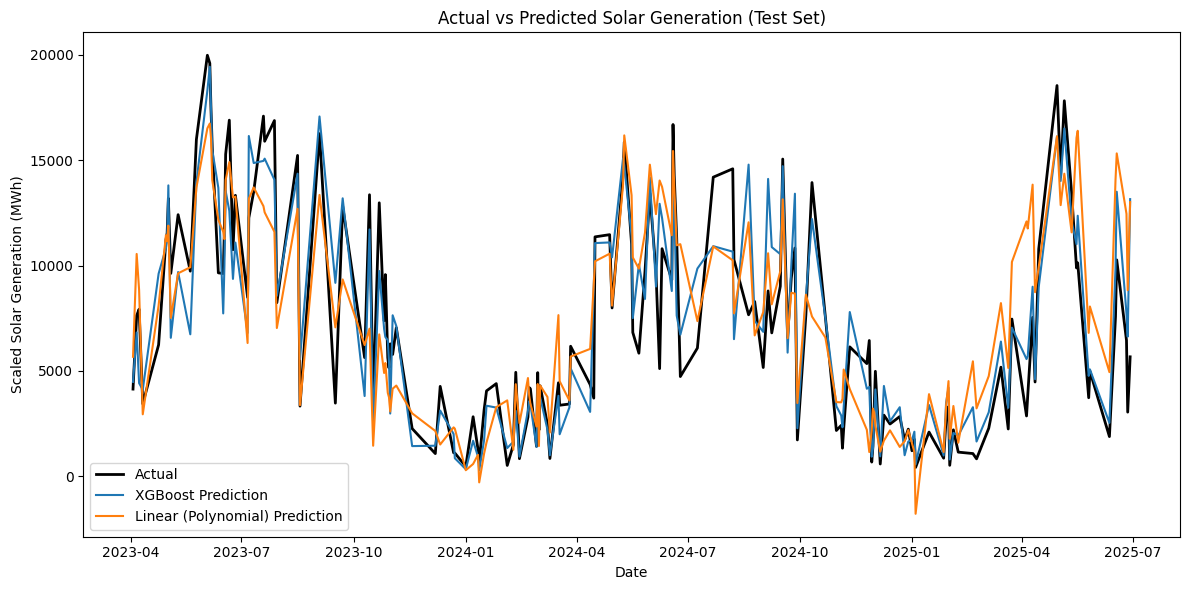

In [26]:
# Align predictions with dates from the test set
test_results = pd.DataFrame({
    "date": dates.iloc[y_test_lin.index],  # test set dates (same for both models)
    "actual": y_test_lin,
    "linear_pred": y_pred_test_lin,
    "xgb_pred": y_pred_test_xgb
}).sort_values("date")

plt.figure(figsize=(12, 6))
plt.plot(test_results["date"], test_results["actual"], label="Actual", color="black", linewidth=2)
plt.plot(test_results["date"], test_results["xgb_pred"], label="XGBoost Prediction", color="tab:blue")
plt.plot(test_results["date"], test_results["linear_pred"], label="Linear (Polynomial) Prediction", color="tab:orange")

plt.xlabel("Date")
plt.ylabel("Scaled Solar Generation (MWh)")
plt.title("Actual vs Predicted Solar Generation (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


### Plot: Actual vs Predictions — Test Set (2025 Only)

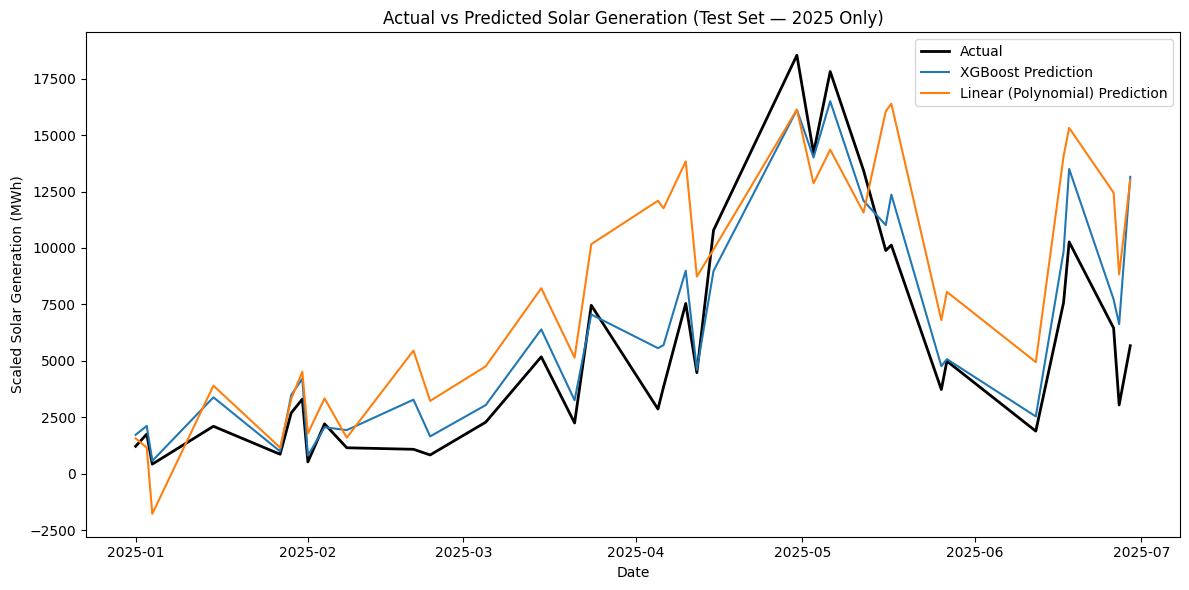

In [27]:
# Filter for 2025
test_results_2025 = test_results[test_results['date'].dt.year == 2025]

plt.figure(figsize=(12, 6))
plt.plot(test_results_2025["date"], test_results_2025["actual"], label="Actual", color="black", linewidth=2)
plt.plot(test_results_2025["date"], test_results_2025["xgb_pred"], label="XGBoost Prediction", color="tab:blue")
plt.plot(test_results_2025["date"], test_results_2025["linear_pred"], label="Linear (Polynomial) Prediction", color="tab:orange")

plt.xlabel("Date")
plt.ylabel("Scaled Solar Generation (MWh)")
plt.title("Actual vs Predicted Solar Generation (Test Set — 2025 Only)")
plt.legend()
plt.tight_layout()
plt.show()

